In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [2]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import cv2
import shutil
import PIL

Using plaidml.keras.backend backend.


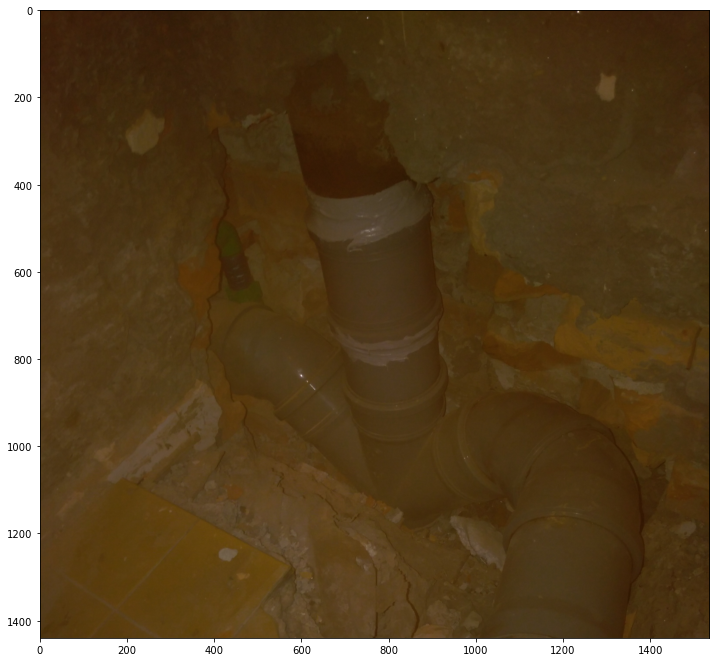

In [3]:
background_path = "../../background_images/pipes.png"

background_image = cv2.imread(background_path)
background_image = cv2.cvtColor(background_image, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(12,12))
plt.imshow(background_image)

'./test/test/test.png'

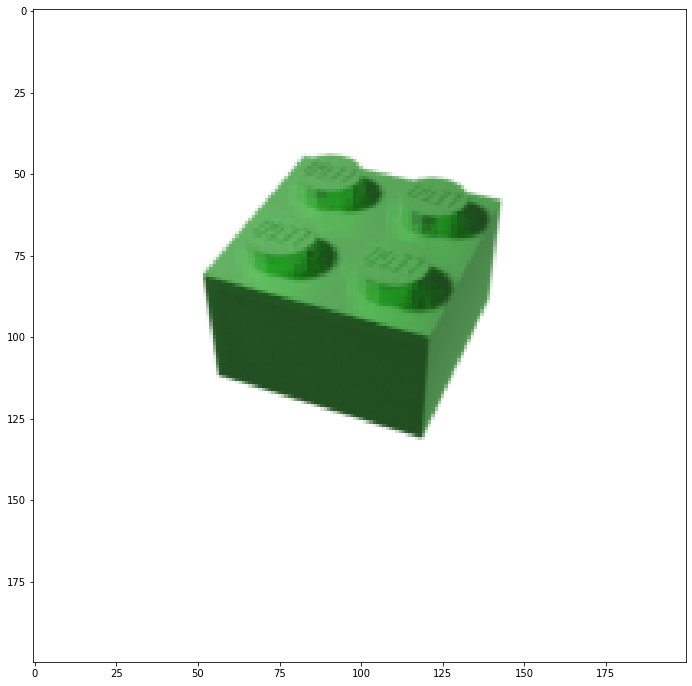

In [4]:
image_path = "../../LEGO_brick_custom/3003 Brick 2x2/test_6_20.png"
object_image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(12,12))
plt.imshow(object_image)

test_dir = "./test"
test_path = "./test/test/test.png"
shutil.copyfile(image_path, test_path)

In [5]:

def crop_random_shape_from_image(image: np.ndarray, cutter_shape: tuple = (200,200), verbose: bool = False) -> np.ndarray:
    '''Crop a randomly placed cutter_shape sized box from given image and returns it'''
    if(verbose):
        print(image.shape)
        print(cutter_shape)

    shape = image.shape

    if(cutter_shape[0] > shape[0] or cutter_shape[1] > shape[1]):
        raise ValueError("Cutter shape ", cutter_shape, " larger than one or more dimensions of given picture shape", shape[:2])
    
    x_1 = np.random.randint(0, shape[0] - cutter_shape[0])
    x_2 = x_1 + cutter_shape[0]

    y_1 = np.random.randint(0, shape[1] - cutter_shape[1])
    y_2 = y_1 + cutter_shape[1]

    if(verbose):
        print(x_1, x_2, y_1, y_2)
    
    result = image[x_1:x_2, y_1:y_2]
    
    return result

In [6]:
def overlay_transparent(background, overlay, x = 0, y = 0):

    background_width = background.shape[1]
    background_height = background.shape[0]

    if x >= background_width or y >= background_height:
        raise ValueError("Image problem")

    h, w = overlay.shape[0], overlay.shape[1]

    if x + w > background_width:
        w = background_width - x
        overlay = overlay[:, :w]

    if y + h > background_height:
        h = background_height - y
        overlay = overlay[:h]

    if overlay.shape[2] < 4:
        raise ValueError("Not transparent")

    overlay_image = overlay[..., :3]
    mask = overlay[..., 3:]

    background[y:y+h, x:x+w] = (1.0 - mask) * background[y:y+h, x:x+w] + mask * overlay_image

    return background

In [24]:
class Background_source:

    def load_images(self):
        for img in os.listdir(self.path):
            img = cv2.imread(os.path.join(self.path, img))
            if(img is not None):
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                self.background_images.append(img)
    
    def __init__(self, directory_path:str, crop_shape:tuple=(200,200)):
        self.path = directory_path
        self.crop_shape = crop_shape
        self.background_images = []

        self.load_images()
    
    def apply_background(self, image):
        background = crop_random_shape_from_image(self.background_images[np.random.randint(len(self.background_images))], self.crop_shape)
        background = cv2.blur(background, (3,3))
        background = np.asarray(background, np.float32)
        background = background[:,:] / 255

        result = overlay_transparent(background, image / 255)

        alpha = np.ones(result.shape[:2])
        result = np.dstack((result, alpha)).astype(np.float32)
        result = result * 255

        return result

In [25]:
from keras.preprocessing.image import ImageDataGenerator

bg = Background_source("../../background_images", (200,200))

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=10,
    zoom_range=0.1,
    height_shift_range=0.1,
    width_shift_range=0.1,
    brightness_range=[0.5,1],
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function = bg.apply_background
)

train_generator = train_datagen.flow_from_directory(test_dir, target_size=(200,200), color_mode="rgba", shuffle=True, class_mode="categorical")

Found 1 images belonging to 1 classes.


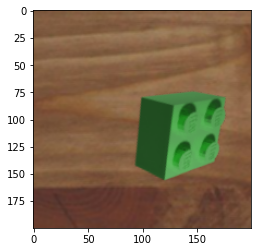

In [30]:
img = train_generator.next()[0][0]
plt.imshow(img)

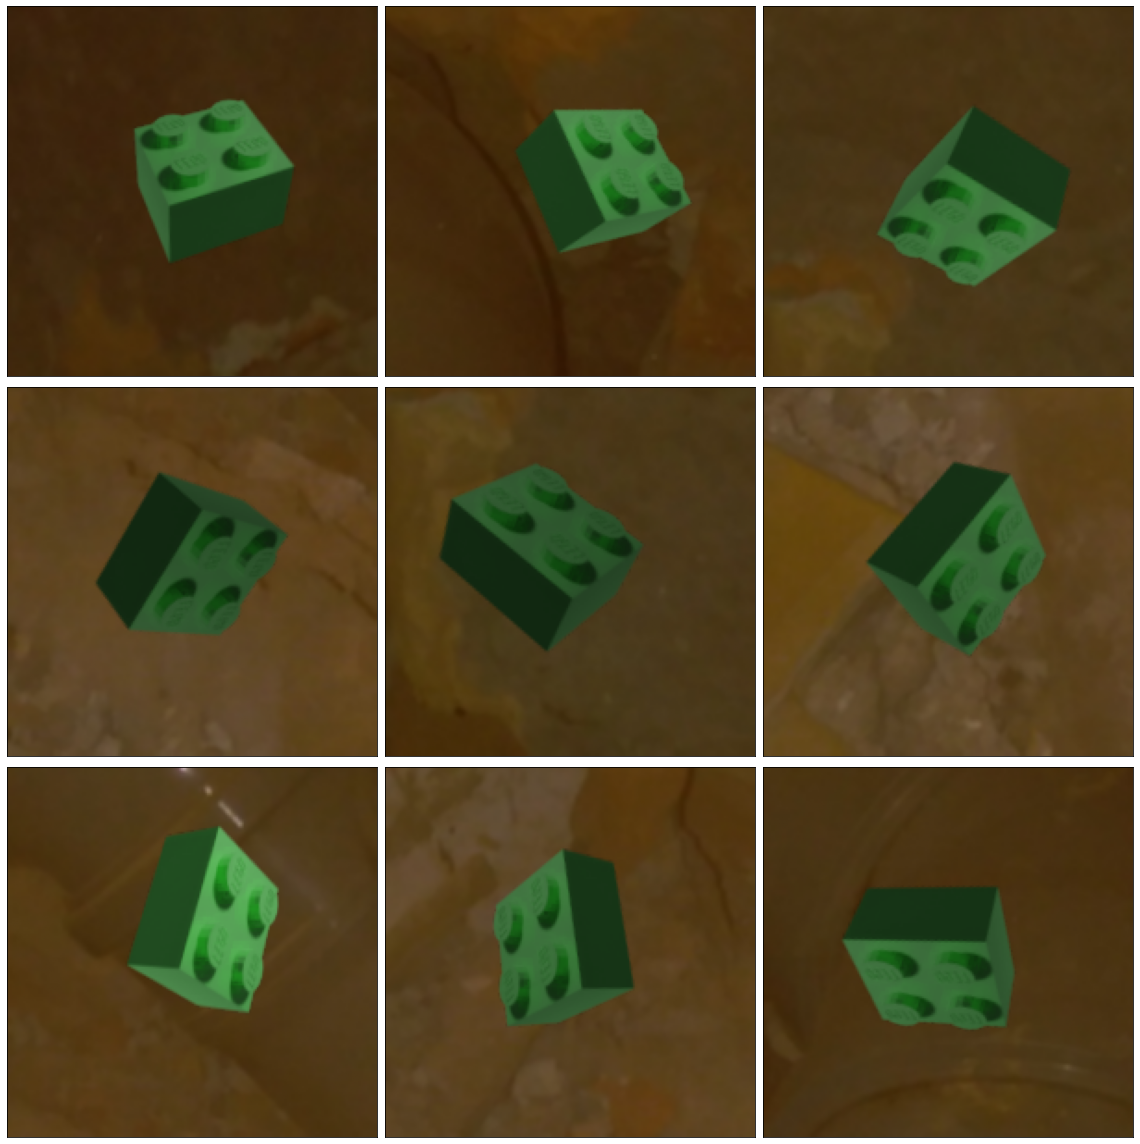

In [13]:
plt.figure(figsize=(16,16))

for i in range(9):
    plt.subplot(330+1+i)
    plt.tick_params(
        axis="both",
        which = "both",
        bottom=False,
        top=False,
        left=False,
        right=False,
        labelleft=False,
        labelbottom=False
    )
    batch = train_generator.next()[0][0]

    img = crop_random_shape_from_image(background_image)
    img = cv2.blur(img, (3,3))
    img = img[:,:] / 255

    final = overlay_transparent(img, batch)


    plt.imshow(final)
plt.tight_layout()
plt.savefig("AAA.png", transparent=True)
plt.show()